# Assignment 10

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = './data/DiabeticRetinopathy/images/' # replace with your path
LABEL_PATH = './data/DiabeticRetinopathy/labels/' # replace with your path

2025-03-23 16:24:53.041985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:
(a) source of image: These images are provided by Aravind Eye Hospital in India.

(b) labelling procedure: Their technician travel to rural areas to capture these images and rely on highly trained doctors to review these images and provide diagnoises.These diagnosis have five possible ratings, 0,1,2,3,4. (labels)

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [2]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [3]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?


Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

/var/folders/kh/j_7lbx657ybg_j1nwtbxjy040000gn/T/ipykernel_13944/2184493929.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels['diagnosis'], palette="viridis")


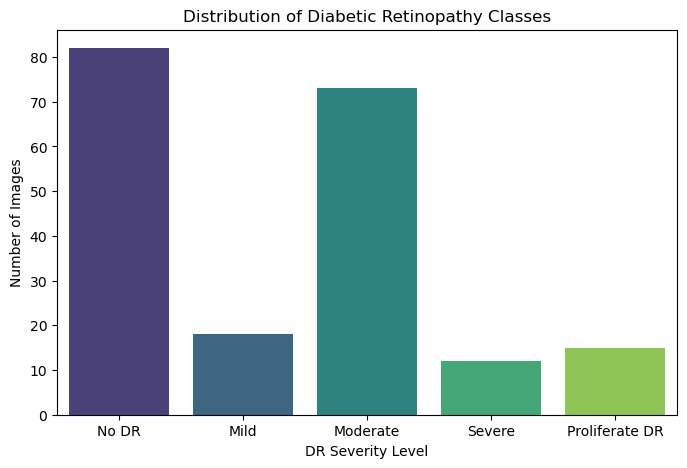

In [4]:
# YOUR CODE HERE
# Plot the histogram of DR classes
plt.figure(figsize=(8, 5))
sns.countplot(x=labels['diagnosis'], palette="viridis")

# Add labels and title
plt.xlabel("DR Severity Level")
plt.ylabel("Number of Images")
plt.title("Distribution of Diabetic Retinopathy Classes")
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["No DR", "Mild", "Moderate", "Severe", "Proliferate DR"])

# Show plot
plt.show()


Comment on class balance: some classes e.g. DR Sev level "Mild" and "Severe" and "Proliferate DR" have significantly fewer samples, compared to "Moderate" and "No DR" -  the dataset is imbalanced (this is generally common in medical datasets).

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

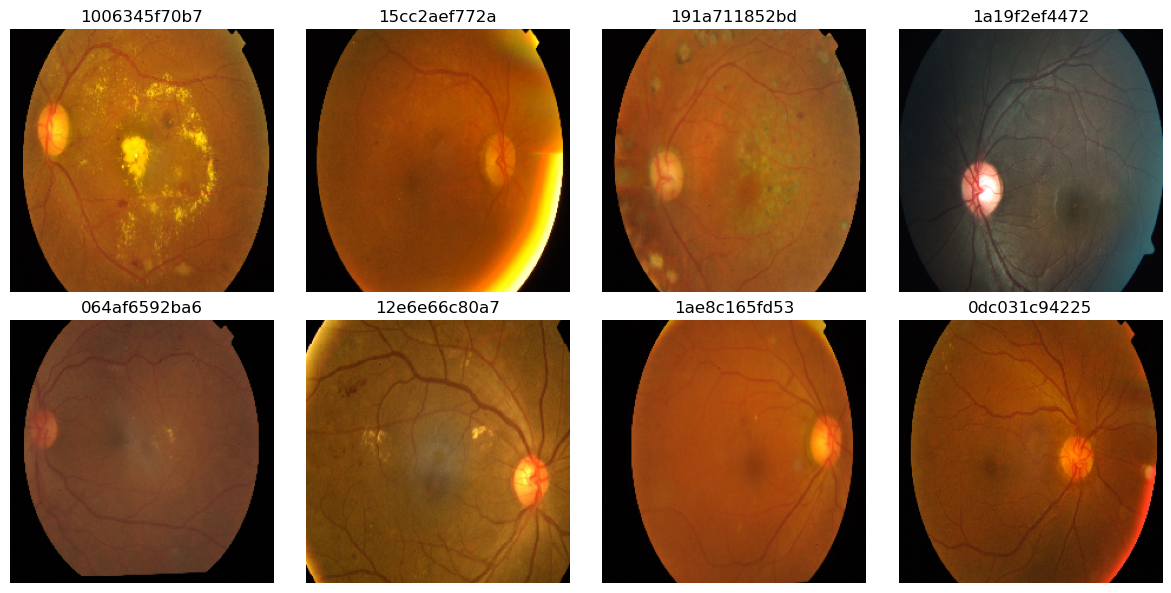

In [5]:
# FILL IN CODE HERE #
# Randomly select 8 images from the dataset
sample_images = random.sample(os.listdir(IMAGE_PATH), 8)

# Plot the 8 images for inspection
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for img_name, ax in zip(sample_images, axes.flatten()):
    img_path = os.path.join(IMAGE_PATH, img_name)
    img = load_img(img_path, target_size=(224, 224))  # Resize for uniformity
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name.split('.')[0])  # Set title to image ID (no file extension)

plt.tight_layout()
plt.show()


Comment on the size, focus/orientation of the 8 images: All images don't have same orientation. Some of left and others are left oriented. There is also mix of grey scale images.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [6]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [7]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [8]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [9]:
import numpy as np
import tensorflow as tf

def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformations and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation, and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """
    
    # Set random seed for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # Shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # Create data splits
    train_size = int(splits[0] * len(images))
    val_size = int(splits[1] * len(images))
    
    X_train, X_temp, y_train, y_temp = images[:train_size], images[train_size:], labels[:train_size], labels[train_size:]
    X_val, X_test, y_val, y_test = X_temp[:val_size], X_temp[val_size:], y_temp[:val_size], y_temp[val_size:]
    
    # Image augmentation (random flip) on training data
    X_train_augm = [tf.image.flip_left_right(img).numpy() for img in X_train]
    X_train_augm = np.array(X_train_augm)

    # Ensure `X_train` is a NumPy array before concatenation
    X_train = np.array(X_train)  

    # Concatenate original X_train and augmented X_train
    X_train = np.concatenate([X_train, X_train_augm], axis=0)

    # Concatenate y_train (preserve original labels)
    y_train_augm = np.array(y_train)
    y_train = np.concatenate([y_train, y_train_augm], axis=0)

    # Shuffle X_train and y_train in the same order
    shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle_indices).numpy()
    y_train = tf.gather(y_train, shuffle_indices).numpy()

    # Rescale images
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this *model_tf*):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the tf.keras.Model.fit() method returns.
11. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets. 

In [11]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.4813 - loss: 424.0944 - val_accuracy: 0.7500 - val_loss: 4.7632
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.5161 - loss: 3.8086 - val_accuracy: 0.3438 - val_loss: 0.7030
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5112 - loss: 0.6930 - val_accuracy: 0.3438 - val_loss: 0.7081
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5112 - loss: 0.6933 - val_accuracy: 0.3438 - val_loss: 0.7129
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5112 - loss: 0.6937 - val_accuracy: 0.3438 - val_loss: 0.7161
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.5112 - loss: 0.6941 - val_accuracy: 0.3438 - val_loss: 0.7174
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5112 - loss: 0.6942 - val_accuracy: 0.3438 - val_loss: 0.7171
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


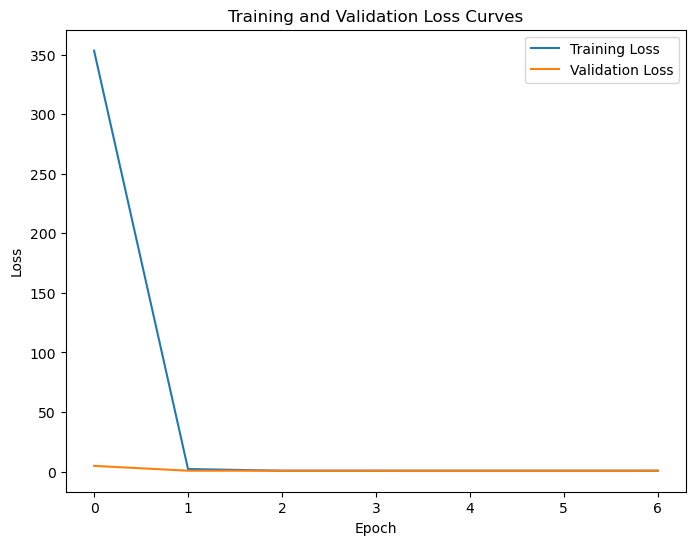

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5813 - loss: 0.6887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3438 - loss: 0.7030
Training Accuracy: 0.5312
Validation Accuracy: 0.3438


In [12]:

tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
### YOUR CODE HERE ###
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1',
    input_shape=(224, 224, 3)
))

# add max pooling layer 
### YOUR CODE HERE ###
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
### YOUR CODE HERE ###
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
### YOUR CODE HERE ###
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
### YOUR CODE HERE ###
model_tf.summary()

# train model_tf on (X_train, y_train) data
### YOUR CODE HERE ###
history = model_tf.fit(X_train, y_train,
                        epochs=20,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=1)

# plot loss curves
### YOUR CODE HERE ###
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
### YOUR CODE HERE ###
train_loss, train_acc = model_tf.evaluate(X_train, y_train, verbose=1)
val_loss, val_acc = model_tf.evaluate(X_val, y_val, verbose=1)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

How many parameters does *model_tf* have? 151,117

Comment on *model_tf* accuracy on training vs. validation data: 
The training accuracy is (53.12%) , but validation accuracy (34.38%) is very low.
This model offers poor generalization capability as this may be overfitting to training data while failing to learn meaningful patterns.

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

In [13]:
### YOUR CODE HERE ###
# Initialize the model
model_tf_tuned = tf.keras.Sequential()

# Add first convolutional layer
model_tf_tuned.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same', name='conv_1'))

# Add second convolutional layer
model_tf_tuned.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv_2'))

# Add max-pooling layer
model_tf_tuned.add(layers.MaxPooling2D(pool_size=(2, 2), name='max_pool'))

# Flatten the output
model_tf_tuned.add(layers.Flatten(name='flatten'))

# Add dropout after flattening
model_tf_tuned.add(layers.Dropout(0.5, name='dropout'))

# Add fully connected dense layer
model_tf_tuned.add(layers.Dense(128, activation='relu', name='dense_1'))

# Add another dropout layer
model_tf_tuned.add(layers.Dropout(0.5, name='dropout_1'))

# Add the final dense layer with 1 neuron for binary classification
model_tf_tuned.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

# Compile the model
model_tf_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Print model summary
model_tf_tuned.summary()

# Evaluate fine-tuned model
train_loss, train_acc = model_tf_tuned.evaluate(X_train, y_train)
val_loss, val_acc = model_tf_tuned.evaluate(X_val, y_val)

print(f"Fine-Tuned Model Training Accuracy: {train_acc:.4f}")
print(f"Fine-Tuned Model Validation Accuracy: {val_acc:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (MaxPooling2D)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │   102,760,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,780,097 (392.07 MB)

 Trainable params: 102,780,097 (392.07 MB)

 Non-trainable params: 0 (0.00 B)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - accuracy: 0.4187 - loss: 0.7061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6562 - loss: 0.6753
Fine-Tuned Model Training Accuracy: 0.4688
Fine-Tuned Model Validation Accuracy: 0.6562


How many parameters does your fine-tuned model have? 102,780,097

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version? 

Yes there is an improvement.
The fine-tuned Model has the training accuracy of 46% and and validation accuracy of 65%. 

The non-fine-tuned model has training accuracy of 53% and validation accuracy of 34%.

The fined-tuned model has increases training accuracy and significantly higher validation accuracy.

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [14]:
### YOUR CODE HERE ###
# Evaluate fine-tuned model on test data
test_loss, test_acc = model_tf_tuned.evaluate(X_test, y_test)

print(f"Fine-Tuned Model Test Accuracy: {test_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - accuracy: 0.4375 - loss: 0.7018
Fine-Tuned Model Test Accuracy: 0.4375


Does your model generalize well? 
Test accuracy is 43%, which indicates that the fine-tuned model is still not generalizing very well on the unseen data.